# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [2]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize

HOC_NUM = 5
DATA_SZ = -1

In [9]:
train_data, val_data, test_data, ast_id_to_row_map, row_to_ast_id_map, num_timesteps, num_asts =\
utils.load_dataset_predict_ast(hoc_num=HOC_NUM, data_sz=DATA_SZ)

(4195, 7, 432)
(4195, 7, 432)
Preparing network inputs and targets...
(3670, 6, 432)
(3670, 6)
(262, 6, 432)
(263, 6, 432)
6
Inputs and targets done!


In [10]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 2e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 10
dropout_p = 0.5
num_lstm_layers = 2
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [11]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


/Users/lisa1010/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [12]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training...
Total training iterations: 1140
Ep 0 	iter 1  	loss 6.06765, train acc 0.00, train corr acc 0.00, val acc 62.28, val corr acc 24.62
Ep 0 	iter 2  	loss 5.66984, train acc 59.90, train corr acc 23.00, val acc 66.79, val corr acc 33.42
Ep 0 	iter 3  	loss 1.86565, train acc 70.31, train corr acc 35.96, val acc 66.79, val corr acc 33.42
Ep 0 	iter 4  	loss 2.64516, train acc 60.42, train corr acc 29.63, val acc 66.73, val corr acc 33.29
Ep 0 	iter 5  	loss 2.10575, train acc 67.71, train corr acc 34.04, val acc 63.30, val corr acc 33.16
Ep 0 	iter 6  	loss 2.20798, train acc 63.54, train corr acc 35.71, val acc 66.98, val corr acc 33.80
Ep 0 	iter 7  	loss 1.60937, train acc 71.35, train corr acc 36.78, val acc 66.60, val corr acc 33.04
Ep 0 	iter 8  	loss 1.88699, train acc 64.58, train corr acc 32.67, val acc 63.87, val corr acc 28.95
Ep 0 	iter 9  	loss 1.91909, train acc 60.42, train corr acc 27.62, val acc 63.10, val corr acc 27.93
Ep 0 	iter 10  	loss 1.99862, t

KeyboardInterrupt: 

In [16]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, row_to_ast_id_map, dataset_name='test')

Testing...
Final results:
  test loss:			1.107700
  test raw accuracy:		74.59 %
  test corrected accuracy:	51.04 %


In [17]:
# Convert to AST IDs so we can look at the AST json files
X_test_ast_ids, y_test_ast_ids = utils.convert_data_to_ast_ids(test_data, row_to_ast_id_map)
pred_test_ast_ids = utils.convert_pred_to_ast_ids(pred_test, row_to_ast_id_map)
print("X AST IDs")
print X_test_ast_ids[:10,:]
print ("Truth AST IDs")
print y_test_ast_ids[:10, :]
print("Predicted AST IDs")
print pred_test_ast_ids[:10,:]

X AST IDs
[[   1.   75.   29.   -1.   -1.   -1.]
 [  13.   74.    0.   -1.   -1.   -1.]
 [ 214.   14.   -1.   -1.   -1.   -1.]
 [   1.    8.    3.    0.   -1.   -1.]
 [   1.    3.    7.    9.   -1.   -1.]
 [   5.    1.    5.    0.   -1.   -1.]
 [  38.    1.   -1.   -1.   -1.   -1.]
 [   2.   27.    0.   -1.   -1.   -1.]
 [   1.    4.   11.    2.    0.   -1.]
 [ 498.    0.   -1.   -1.   -1.   -1.]]
Truth AST IDs
[[ 75.  29.  -1.  -1.  -1.  -1.]
 [ 74.   0.  -1.  -1.  -1.  -1.]
 [ 14.  -1.  -1.  -1.  -1.  -1.]
 [  8.   3.   0.  -1.  -1.  -1.]
 [  3.   7.   9.  -1.  -1.  -1.]
 [  1.   5.   0.  -1.  -1.  -1.]
 [  1.  -1.  -1.  -1.  -1.  -1.]
 [ 27.   0.  -1.  -1.  -1.  -1.]
 [  4.  11.   2.   0.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.]]
Predicted AST IDs
[[   4.   66.    0.   -1.   -1.   -1.]
 [  74.   27.   -1.   -1.   -1.   -1.]
 [   0.   -1.   -1.   -1.   -1.   -1.]
 [   4.    3.    0.   -1.   -1.   -1.]
 [   4.   11.    0.   -1.   -1.   -1.]
 [   3.    0.    0.   -1.   -1.   -1.]
 [

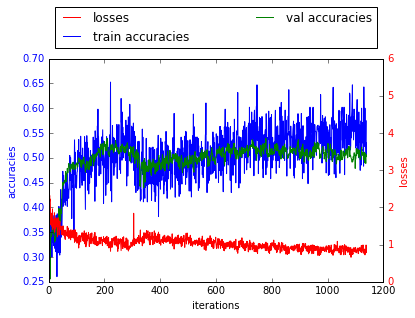

In [20]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
visualize.plot_loss_acc(DATA_SET + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')

Below are more trial runs

In [27]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.95
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 4
dropout_p = 0.2
num_lstm_layers = 2
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [25]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
